# Model Comparison
By: Griffin Hosseinzadeh (2025 May 7)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

We'll start by generating some synthetic data from a slightly more complicated model than usual. The true underlying model will be a straight line plus a sinusoid. Imagine, for example, that these data are measurements of the brightness of a variable star over time. It could have short-timescale oscillations in brightness while also increasing in average brightness over the long term. Let's model this as
$$ y_3(x) = m x + b + a\sin(2\pi x) $$
where the three model parameters are the slope $m$, the intercept $b$, and the amplitude of the oscillations $a$.
We're going to compare this model with a simpler model without the oscillations:
$$ y_2(x) = m x + b $$
When we have noisy data, we may not be able to tell the difference between these two models.

First, write both these models down as functions. We will want to call them later on.

In [6]:
def model3(x, m, b, a):
    y = (m * x) + b + (a * np.sin(2 * np.pi * x))
    return y

def model2(x, m, b):
    y = m * x + b
    return y

Generate 100 random points in the range $0<x<1$ and evaulate the true model ($y_3$) at these points given the parameters below. Then add Gaussian noise to each point using the value of $\sigma$ below. Plot your synthetic data set (with error bars) and visually compare it with your two proposed models.

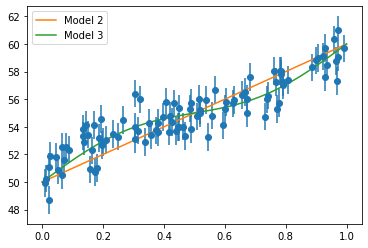

In [18]:
N = 100       # number of points
m_true = 10.  # slope
b_true = 50.  # intercept
a_true = 1.   # amplitude
sigma = 1.    # scatter

rng = np.random.default_rng(seed=13579)
x = rng.uniform(0, 1, size = N)
y_noise_free = model3(x, m_true, b_true, a_true)
y = y_noise_free + rng.normal(0, sigma, size = N)
dy = np.full(N, sigma)

x_model = np.linspace(0, 1, 1000)
y_model2 = model2(x_model, m_true, b_true)
y_model3 = model3(x_model, m_true, b_true, a_true)

plt.errorbar(x, y, yerr = dy, fmt = 'o')
plt.plot(x_model, y_model2, label = 'Model 2')
plt.plot(x_model, y_model3, label = 'Model 3')
plt.legend()

From now on, we are pretending we don't know which model is true, or what the true values of the parameters are. We have a data set, and we want to figure out which model is a a better fit, and whether it is significantly better or not, given the different numbers of parameters.

For each model, write down functions for the logarithm of the prior, likelihood, and posterior. **Make sure your prior is properly normalized.** Use these functions to calculate the Bayesian evidence for each model. This is very similar to what we did in the Bayesian statistics exercise, with one additional step: numerical integration (`np.trapezoid`) of the entire posterior grid.

In [8]:
m_min = 0.5
m_max = 99.5
b_min = 0.5
b_max = 99.5

def log_prior2(theta):
    m_mod, b_mod = theta
    if m_min < m_mod < m_max:
        prob_m = 1. / (m_mod * np.log(m_max / m_min))
    else:
        prob_m = 0.
    if b_min < b_mod < b_max:
        prob_b = 1. / (b_max - b_min)
    else:
        prob_b = 0.
    prob_total = prob_m * prob_b
    ln_prior = np.log(prob_total)
    return ln_prior

def log_likelihood2(theta, x, y, dy):
    m_mod, b_mod = theta
    y_model = m_mod * x + b_mod
    chi2 = (y - y_model) ** 2. / dy ** 2.
    ln_like = -0.5 * np.sum(chi2)
    return ln_like

def log_posterior2(theta, x, y, dy):
    ln_post = log_prior2(theta) + log_likelihood2(theta, x, y, dy)
    return ln_post

m_range2 =  np.linspace(m_min, m_max, 200)
b_range2 = np.linspace(b_min, b_max, 200)


m_grid2, b_grid2 = np.meshgrid(m_range2, b_range2, indexing='ij')

posterior_grid2 =  posterior_grid2 = np.zeros_like(m_grid2)

for i in range(len(m_range2)):
    for j in range(len(b_range2)):
        theta = (m_range2[i], b_range2[j])
        posterior_grid2[i, j] = np.exp(log_posterior2(theta, x, y, dy))

evidence2 =  np.trapz(np.trapz(posterior_grid2, 
                                       b_range2, axis=1), 
                          m_range2, axis=0)
print(evidence2)

/var/folders/g7/tfxp633s42vgtl5_b9qmp7w00000gn/T/ipykernel_4021/1923752328.py:17: RuntimeWarning: divide by zero encountered in log
  ln_prior = np.log(prob_total)


1.1139894284652674e-28


In [9]:
a_min = 0.1
a_max = 10.

def log_prior3(theta):
     
    m_mod, b_mod, a_mod = theta
    if m_min < m_mod < m_max:
        prob_m = 1. / (m_mod * np.log(m_max / m_min))
    else:
        prob_m = 0.
    if b_min < b_mod < b_max:
        prob_b = 1. / (b_max - b_min)
    else:
        prob_b = 0.
    if a_min < a_mod < a_max:
        prob_a = 1. / (a_max - a_min)
    else:
        prob_a = 0.

    prob_total = prob_m * prob_b * prob_a
    if prob_total == 0.:
        return -np.inf
    else:
        ln_prior = np.log(prob_total)
        return ln_prior

def log_likelihood3(theta, x, y, dy):    
    m_mod, b_mod, a_mod = theta
    y_model = m_mod * x + b_mod + a_mod * np.sin(2 * np.pi * x)
    chi2 = (y - y_model) ** 2. / dy ** 2.
    return -0.5 * np.sum(chi2)


def log_posterior3(theta, x, y, dy):
    ln_post = log_prior3(theta) + log_likelihood3(theta, x, y, dy)
    return ln_post

m_range3 =  np.linspace(m_min, m_max, 100)
b_range3 =  np.linspace(b_min, b_max, 100)
a_range3 = np.linspace(a_min, a_max, 100)

posterior_grid3 = np.zeros((len(m_range3), len(b_range3), len(a_range3)))

for i, m_val in enumerate(m_range3):
    for j, b_val in enumerate(b_range3):
        for k, a_val in enumerate(a_range3):
            theta3 = (m_val, b_val, a_val)
            posterior_grid3[i, j, k] = np.exp(log_posterior3(theta3, x, y, dy))

evidence3 =  np.trapz(np.trapz(np.trapz(posterior_grid3, 
                                        a_range3, axis=2), 
                               b_range3, axis=1), 
                      m_range3, axis=0)
print(evidence3)

1.3137782847121085e-27


Calculate the odds ratio for the 3-parameter model compared to the 2-parameter model. What does this number tell you? Does it agree with your intuition from the plot you made above?

In [11]:
bayefact = evidence3 / evidence2
print("Bayes factor (Model 3 against 2):", bayefact)

Bayes factor (Model 3 against 2): 11.793453789970775


The Bayes factor is in favor of model 3, which is correct as the data has a sinusoidal shape to it.

Now calculate the Akaike and Bayesian information criteria (AIC & BIC). For the sake of time, do not worry about determining the actual maximum-likelihood parameter values. Just use the true parameter values we used to synthesize the data at the beginning of this notebook. (Presumably those should be close to the maximum-likelihood values.) What do the AIC and BIC tell you? Do they agree with the odds ratio and/or your intuition?

In [12]:
N = 100
k2 = 2
k3 = 3

theta2_true = (m_true, b_true)
theta3_true = (m_true, b_true, a_true)
Log_Lik2 = log_likelihood2(theta2_true, x, y, dy)
Log_Lik3 = log_likelihood3(theta3_true, x, y, dy)

aic2 =  -2 * Log_Lik2 + 2 * k2
aic3 =  -2 * Log_Lik3 + 2 * k3
print("AIC model 2:", aic2, "AIC model 3:", aic3, "Change in AIC:", aic2 - aic3)

bic2 =  -2 * Log_Lik2 + 2 * k2 * np.log(N)
bic3 =  -2 * Log_Lik3 + 2 * k3 * np.log(N)
print("BIC model 2:", bic2, "BIC model 3:", bic3, "Change in BIC:", bic2 - bic3)

AIC model 2: 154.6541887882873 AIC model 3: 106.49753650860667 Change in AIC: 48.15665227968064
BIC model 2: 169.0748695322397 BIC model 3: 128.12855762453523 Change in BIC: 40.946311907704455


The change in AIC is higher than the change in BIC supporting the odds ratio. The additional sin term in model 3 fits the data more appropriately. 

Now repeat this entire notebook using a different data set with increased noise. Either duplicate this entire notebook (File > Duplicate), in which case you need to add that new notebook to the GitHub repository, or copy all the code cells above and paste them below. *(Yes, you could just change the number and rerun the notebook, but we want to see a record of both.)*

This time, increase $\sigma$ to 5. Comment on your results, specifically whether or not you can distinguish between the two models, and whether you think that is reasonable or not.

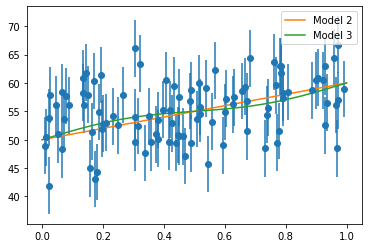

In [19]:
N = 100       # number of points
m_true = 10.  # slope
b_true = 50.  # intercept
a_true = 1.   # amplitude
sigma = 5.    # scatter

rng = np.random.default_rng(seed=13579)
x = rng.uniform(0, 1, size = N)
y_noise_free = model3(x, m_true, b_true, a_true)
y = y_noise_free + rng.normal(0, sigma, size = N)
dy = np.full(N, sigma)

x_model = np.linspace(0, 1, 1000)
y_model2 = model2(x_model, m_true, b_true)
y_model3 = model3(x_model, m_true, b_true, a_true)

plt.errorbar(x, y, yerr = dy, fmt = 'o')
plt.plot(x_model, y_model2, label = 'Model 2')
plt.plot(x_model, y_model3, label = 'Model 3')
plt.legend()

In [14]:
m_min = 0.5
m_max = 99.5
b_min = 0.5
b_max = 99.5

def log_prior2(theta):
    m_mod, b_mod = theta
    if m_min < m_mod < m_max:
        prob_m = 1. / (m_mod * np.log(m_max / m_min))
    else:
        prob_m = 0.
    if b_min < b_mod < b_max:
        prob_b = 1. / (b_max - b_min)
    else:
        prob_b = 0.
    prob_total = prob_m * prob_b
    ln_prior = np.log(prob_total)
    return ln_prior

def log_likelihood2(theta, x, y, dy):
    m_mod, b_mod = theta
    y_model = m_mod * x + b_mod
    chi2 = (y - y_model) ** 2. / dy ** 2.
    ln_like = -0.5 * np.sum(chi2)
    return ln_like

def log_posterior2(theta, x, y, dy):
    ln_post = log_prior2(theta) + log_likelihood2(theta, x, y, dy)
    return ln_post

m_range2 =  np.linspace(m_min, m_max, 200)
b_range2 = np.linspace(b_min, b_max, 200)


m_grid2, b_grid2 = np.meshgrid(m_range2, b_range2, indexing='ij')

posterior_grid2 =  posterior_grid2 = np.zeros_like(m_grid2)

for i in range(len(m_range2)):
    for j in range(len(b_range2)):
        theta = (m_range2[i], b_range2[j])
        posterior_grid2[i, j] = np.exp(log_posterior2(theta, x, y, dy))

evidence2 =  np.trapz(np.trapz(posterior_grid2, 
                                       b_range2, axis=1), 
                          m_range2, axis=0)
print(evidence2)

/var/folders/g7/tfxp633s42vgtl5_b9qmp7w00000gn/T/ipykernel_4021/1923752328.py:17: RuntimeWarning: divide by zero encountered in log
  ln_prior = np.log(prob_total)


1.3485701658756973e-24


In [15]:
a_min = 0.1
a_max = 10.

def log_prior3(theta):
     
    m_mod, b_mod, a_mod = theta
    if m_min < m_mod < m_max:
        prob_m = 1. / (m_mod * np.log(m_max / m_min))
    else:
        prob_m = 0.
    if b_min < b_mod < b_max:
        prob_b = 1. / (b_max - b_min)
    else:
        prob_b = 0.
    if a_min < a_mod < a_max:
        prob_a = 1. / (a_max - a_min)
    else:
        prob_a = 0.

    prob_total = prob_m * prob_b * prob_a
    if prob_total == 0.:
        return -np.inf
    else:
        ln_prior = np.log(prob_total)
        return ln_prior

def log_likelihood3(theta, x, y, dy):    
    m_mod, b_mod, a_mod = theta
    y_model = m_mod * x + b_mod + a_mod * np.sin(2 * np.pi * x)
    chi2 = (y - y_model) ** 2. / dy ** 2.
    return -0.5 * np.sum(chi2)


def log_posterior3(theta, x, y, dy):
    ln_post = log_prior3(theta) + log_likelihood3(theta, x, y, dy)
    return ln_post

m_range3 =  np.linspace(m_min, m_max, 100)
b_range3 =  np.linspace(b_min, b_max, 100)
a_range3 = np.linspace(a_min, a_max, 100)

posterior_grid3 = np.zeros((len(m_range3), len(b_range3), len(a_range3)))

for i, m_val in enumerate(m_range3):
    for j, b_val in enumerate(b_range3):
        for k, a_val in enumerate(a_range3):
            theta3 = (m_val, b_val, a_val)
            posterior_grid3[i, j, k] = np.exp(log_posterior3(theta3, x, y, dy))

evidence3 =  np.trapz(np.trapz(np.trapz(posterior_grid3, 
                                        a_range3, axis=2), 
                               b_range3, axis=1), 
                      m_range3, axis=0)
print(evidence3)

1.193355007892552e-25


In [16]:
bayefact = evidence3 / evidence2
print("Bayes factor (Model 3 against 2):", bayefact)

Bayes factor (Model 3 against 2): 0.08849039064405255


In [17]:
N = 100
k2 = 2
k3 = 3

theta2_true = (m_true, b_true)
theta3_true = (m_true, b_true, a_true)
Log_Lik2 = log_likelihood2(theta2_true, x, y, dy)
Log_Lik3 = log_likelihood3(theta3_true, x, y, dy)

aic2 =  -2 * Log_Lik2 + 2 * k2
aic3 =  -2 * Log_Lik3 + 2 * k3
print("AIC model 2:", aic2, "AIC model 3:", aic3, "Change in AIC:", aic2 - aic3)

bic2 =  -2 * Log_Lik2 + 2 * k2 * np.log(N)
bic3 =  -2 * Log_Lik3 + 2 * k3 * np.log(N)
print("BIC model 2:", bic2, "BIC model 3:", bic3, "Change in BIC:", bic2 - bic3)

AIC model 2: 107.13369605539823 AIC model 3: 106.49753650860674 Change in AIC: 0.6361595467914896
BIC model 2: 121.55437679935059 BIC model 3: 128.1285576245353 Change in BIC: -6.574180825184698


The ratio is much lower, and the changes in AIC and BIC are minor, implying that with such a high level of noise, neither model is prefered. 